In [ ]:
!pip install transformers datasets evaluate accelerate


In [ ]:
from datasets import load_dataset

In [ ]:
import pandas as pd

In [ ]:
#reading the data
traintest = pd.read_pickle('./final_aug.pkl')
validation = pd.read_pickle('./final_validation.pkl')

In [ ]:
ttx=traintest['translated_text']
tty=traintest['label']
x_val=validation['translated_text']
y_val=validation['label']

In [ ]:
from sklearn.model_selection import train_test_split
train_ratio = 0.80
x_train, x_test, y_train, y_test = train_test_split(ttx, tty, test_size=1 - train_ratio)


In [ ]:
import pandas as pd
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

def join_text(text_list):
  if isinstance(text_list, list):
      return " ".join(text_list)
  else:
      return text_list

x_train = x_train.apply(join_text)
x_test = x_test.apply(join_text)
x_val = x_val.apply(join_text)

#creiamo il datasetdict come serve a distilbert
d = {'train':Dataset.from_dict({'label':y_train,'text':x_train}),
     'val':Dataset.from_dict({'label':y_val,'text':x_val}),
     'test':Dataset.from_dict({'label':y_test,'text':x_test})
     }

DatasetDict(d)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 880
    })
    val: Dataset({
        features: ['label', 'text'],
        num_rows: 622
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 220
    })
})

In [ ]:
d=DatasetDict(d)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer=AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)

In [ ]:
tokenized_d=d.map(preprocess_function, batched=True)

Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/622 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
import evaluate

In [ ]:
accuracy=evaluate.load("accuracy")

In [ ]:
import numpy as np

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "neutral", 1: "hate"}
label2id = {"neutral": 0, "hate": 1}

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_d["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_d["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_d["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
import tensorflow as tf

model.compile(optimizer=optimizer)

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=1, callbacks=metric_callback)


55/55 [==============================] - 82s 1s/step - loss: 0.4483 - val_loss: 0.2259 - accuracy: 0.9455


In [ ]:
valid_text=tokenized_d['val']['text']
# Tokenize the validation text and convert to input features
valid_encodings = tokenizer(
    valid_text,
    truncation=True,  # Truncate if text is too long
    padding=True,  # Pad to a uniform length
    return_tensors="tf",  # Return TensorFlow tensors
)

# Now, use the encodings for prediction
preds = model.predict(valid_encodings)

20/20 [==============================] - 13s 590ms/step


In [ ]:
preds=np.argmax(preds[0],axis=1)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       310
           1       0.65      0.61      0.63       312

    accuracy                           0.64       622
   macro avg       0.64      0.64      0.64       622
weighted avg       0.64      0.64      0.64       622


Confusion Matrix:


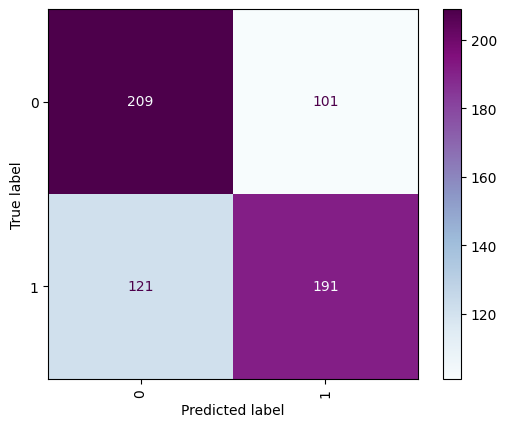

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

print("Classification Report:")
print(classification_report(y_val, preds))
print()

print("Confusion Matrix:")
print(ConfusionMatrixDisplay.from_predictions(y_val, preds, xticks_rotation='vertical', cmap='BuPu'))